# Names Generator v4 - Wavenet 

Learning positional order through WaveNet (explanation below)

1. Input
2. Embedding layer
3. **Flatten Consecutive layer** (NEW)
4. Hidden layer 
4. BatchNorm layer 
5. Output layer 
6. Softmax layer

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


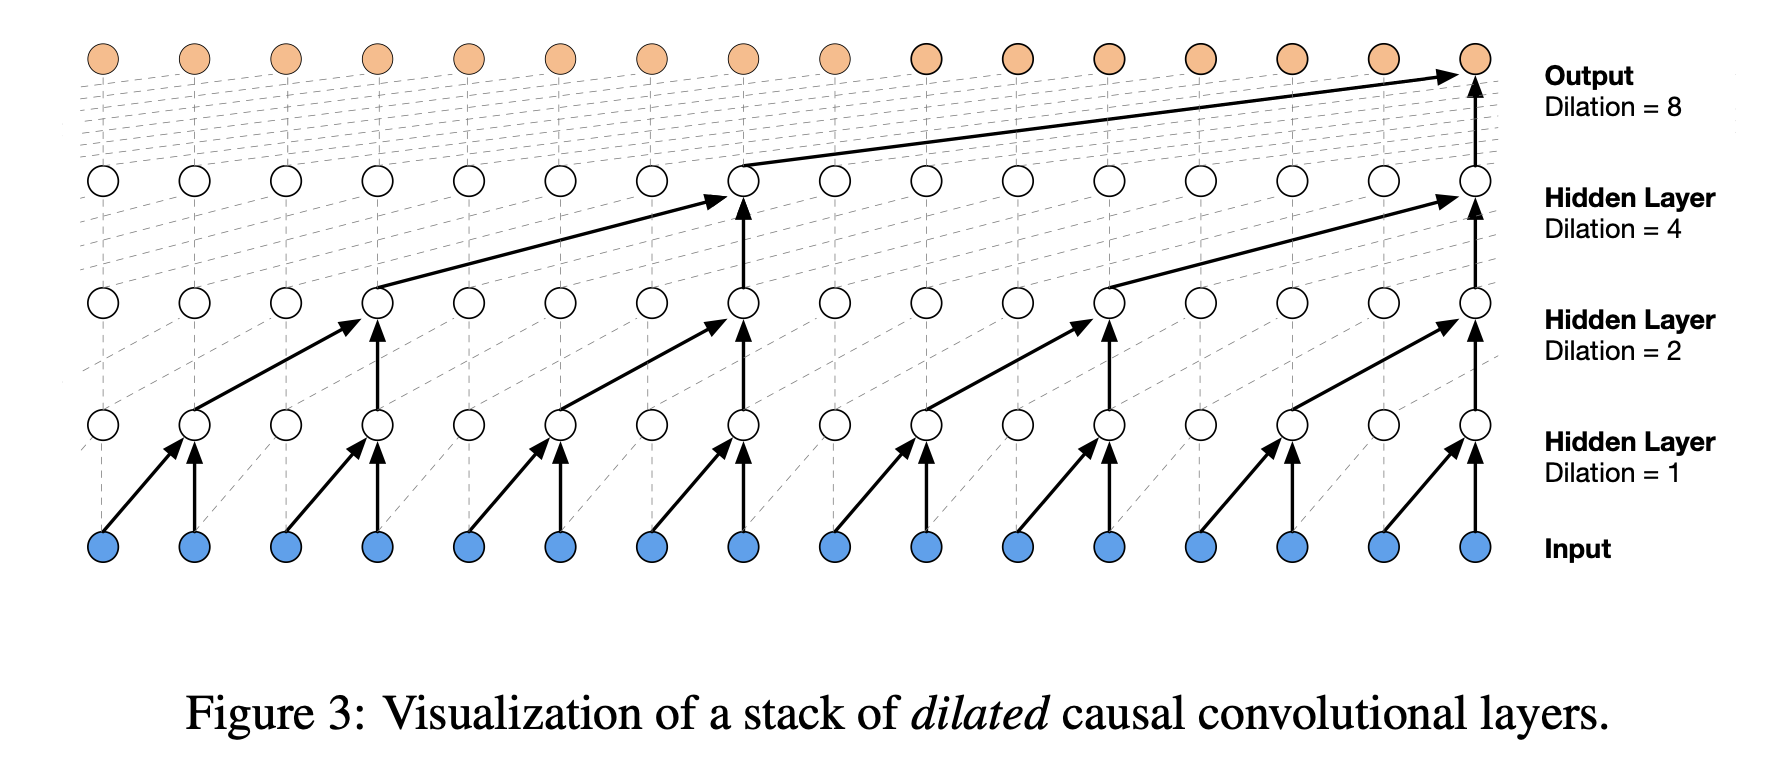

In [ ]:
from IPython.display import Image
Image(filename='images/wavenet.png')

In our previous MLP, for each example, we would pass all the embeddings of the 8 characters into the hidden layer at the same time 
emb = C[Xb]
x = emb.view(emb.shape[0], -1)

* for a batch of 4 examples with context length of 8, each char a 10 dim vector: 
* Xb (4,8)
* Embedding layer output (4,8,10)
* Flatten layer output (4,80) - result of view()
* Current linear  @ W1 + b1: `torch.randn(4, 80) @ torch.randn(80,200) + torch.randn(200)` --> (4, 200)

Now we dont want to flatten out all 8 chars' vectors and do 1 matrix mul. We want to process 4 groups of 2 chars in parallel 
*  (1 2 3 4 5 6 7 8) --> (1 2) (3 4) (5 6) (7 8)
* New: `torch.randn(4, 4, 20) @ torch.randn(20,200) + torch.randn(200)` --> (4, 4, 200) 

In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding: # replace emb = C[Xb]
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive: # replace x = emb.view(emb.shape[0], -1)
  def __init__(self, n):
    self.n = n
    # (1 2) (3 4) (5 6) (7 8) --> n=2 
  
  def __call__(self, x):
    B, T, C = x.shape 
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1: # handling spurious dimension (B, 1, C*n)
      x = x.squeeze(1)

    self.out = x 
    return self.out 

  def parameters(self): 
    return []

# -----------------------------------------------------------------------------------------------
class Sequential: 
  
  def __init__(self, layers):
    self.layers = layers 
    
  def __call__(self, x):
    for layer in self.layers: 
      x = layer(x)
    self.out = x
    return self.out 
  
  def parameters(self): 
    # get params of all layers and stretch them out into 1 list 
    return [p for layer in self.layers for p in layer.parameters()]

In [8]:
torch.manual_seed(42); # seed rng for reproducibility

In [9]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

n_embd = 10 
n_hidden = 64 

model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad(): 
    model.layers[-1].weight *= 0.1 # make last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters: 
    p.requires_grad = True

20073


In [26]:
# same optimisation as part 3 
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps):

    # minibatch construct 
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass 
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward()
    
    # update: simple SGD 
    lr = 0.1 if i <150000 else 0.01 
    for p in parameters: 
        p.data += -lr*p.grad 
    
    # track stats
    if i % 10000 ==0:  
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3026
  10000/ 200000: 1.8686
  20000/ 200000: 2.2283
  30000/ 200000: 2.0487
  40000/ 200000: 2.6062
  50000/ 200000: 2.2266
  60000/ 200000: 2.2891
  70000/ 200000: 2.2984
  80000/ 200000: 2.2128
  90000/ 200000: 2.2651
 100000/ 200000: 2.1352
 110000/ 200000: 2.4476
 120000/ 200000: 2.0540
 130000/ 200000: 1.9266
 140000/ 200000: 1.9233
 150000/ 200000: 2.2376
 160000/ 200000: 1.6648
 170000/ 200000: 1.8233
 180000/ 200000: 2.4697
 190000/ 200000: 1.8458


In [27]:
# Inspect layers tool 
for layer in model.layers: 
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 64)
BatchNorm1d : (32, 4, 64)
Tanh : (32, 4, 64)
FlattenConsecutive : (32, 2, 128)
Linear : (32, 2, 64)
BatchNorm1d : (32, 2, 64)
Tanh : (32, 2, 64)
FlattenConsecutive : (32, 128)
Linear : (32, 64)
BatchNorm1d : (32, 64)
Tanh : (32, 64)
Linear : (32, 27)


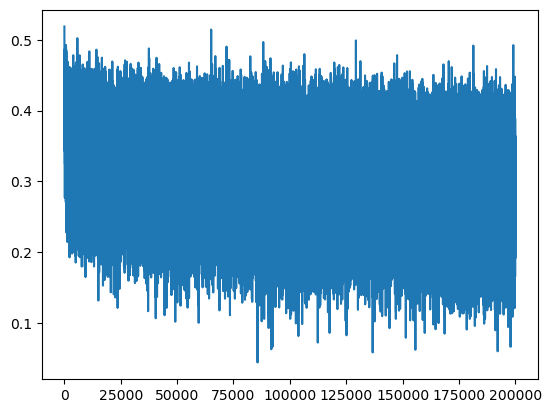

In [28]:
plt.plot(lossi)

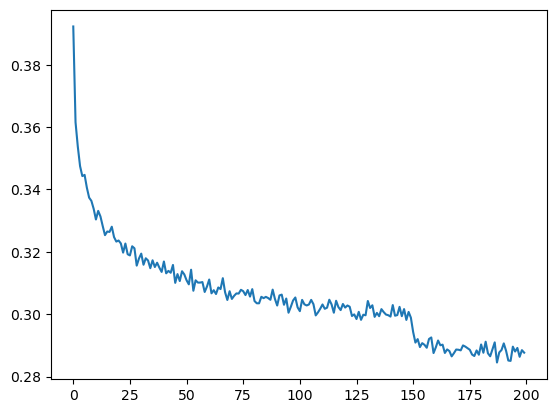

In [29]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))
# lossi array was an array of 200,000 losses
# make it (200,1000), take mean across 1000 losses to plot 200 means 

In [30]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [31]:
# evaluate the loss
@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.920527696609497
val 2.024179220199585


In [32]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

sanay.
zuham.
zaison.
agondre.
karina.
kreku.
joberlee.
mcklon.
thipion.
javid.
sebri.
came.
azanni.
griwai.
bretzon.
luishel.
omasha.
bodion.
arzin.
iyanna.


## A bit about CNNs 

Above we implemented wavenet, and what we achieved is we are able to pass one example (eg. .......d) into a hierarchial structure. 
For the name 'diondre', we have 8 examples we need to pass. Wavenet will do this in a for loop as shown below. 

What CNNs do is allow us to slide this model over the input sequence, so that the for loop is doen not outside in python, but inside kernals in cuda. Convolutions are a for loop applyign a linear filter over space of our input sequence. The for loop is 

In [34]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [35]:
# forward a single example (eg. .......d)
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [36]:
# to forward all the 8 examples, need a for loop
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In this diagram the black lines show the calculation for a single output of a single example. A Convolution allows us to take this black structure and slide it to calculate all the other orange dots (other outputs) across different windows of the input sequence, at the same time.